# 5조 - 오조오억번
# 강우 예측 AI 알고리즘 개발 프로젝트

## 1. Import modules

In [1]:
from google.colab import drive
import zipfile
import glob

import pandas as pd
import numpy as np
np.random.seed(2)

import matplotlib.pylab as plt
import matplotlib.image as mpimg
%matplotlib inline

import PIL.Image as pilimg
import imgaug
import cv2
import itertools
import os
import gc

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error

from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import *   # Conv2D, Conv2DTranspose, MaxPooling2D, MaxPool2D, BatchNormalization, concatenate, Input, Dense, Dropout, UpSampling2D
from tensorflow.keras.models import *   
from tensorflow.keras.optimizers import *   # Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import *

import warnings
warnings.filterwarnings("ignore")

print('tf version:', tf.__version__)

tf version: 2.3.0


## 2. Load train data

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/My Drive/final_prj'

zip_file = zipfile.ZipFile(path+'/train.zip')
zip_file.extractall('.')

In [4]:
# 구글드라이브 train data 파일 경로 지정
train_files = sorted(glob.glob('/content/train/*.npy'))
train_files = np.array(train_files)   # [:1000])    

In [5]:
# C드라이브 train data 파일 경로 지정
# train_files = glob.glob('C:\\AIP\\rainy_project\\venv\\data\\train/*.npy')
# train_files = np.array(train_files[:1000])

In [6]:
print(len(train_files))
print(train_files[1])

62735
/content/train/train_00001.npy


## 3. Split Target vs. Feature

In [7]:
pix=[]
y = []
x = []
for i in range(1000) :   # len(train_files)) :
    im = np.load(train_files[i])
    im.resize(120, 120, 5)
    target= im[:,:,-1]
    feature=[]
    for j in range(4):
        feature.append(im[:,:,j])
    # print(feature[0].type)
    pix.append(im)
    y.append(target)
    x.append(feature)
    if i %5000 == 0:
        print(i)
np.array(x).shape
# x.type

0


(1000, 4, 120, 120)

## 4. Plot

In [8]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()
image_sample_x = x[2]   # np.load(train_files[20])
image_sample_y = y[2]

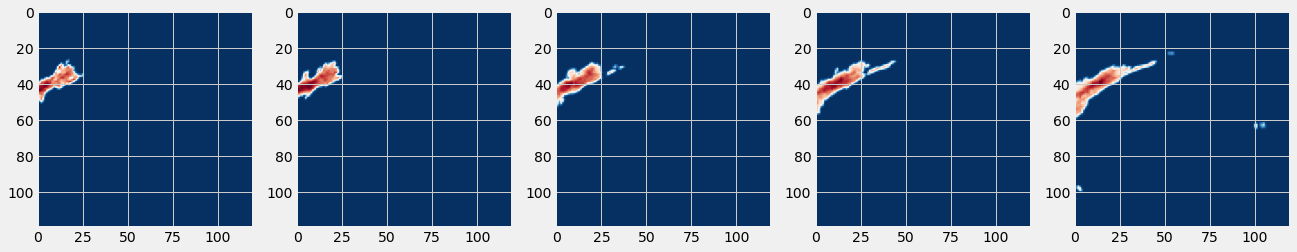

In [9]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 20))
image_sample_x=np.array(image_sample_x)
image_sample_y=np.array(image_sample_y)
for i in range(4):
    plt.subplot(1,5,i+1)
    plt.imshow(image_sample_x[i,:, :], cmap=color_map)

plt.subplot(1,5,5)
plt.imshow(image_sample_y, cmap = color_map)
plt.show()

## 5. Split Training vs. Validation data

In [10]:
x=np.array(x)
y=np.array(y)
x.resize(1000, 4, 120,120,1)
y.resize(1000, 1, 120,120,1)

X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size = 0.2, random_state=42)

In [11]:
np.array(X_train).shape

(800, 4, 120, 120, 1)

In [12]:
np.array(X_val).shape

(200, 4, 120, 120, 1)

In [13]:
np.array(Y_train).shape

(800, 1, 120, 120, 1)

In [14]:
np.array(Y_val).shape

(200, 1, 120, 120, 1)

## 6. Modeling

### - ConvLSTM

In [15]:
model = keras.Sequential(
    [
        keras.Input(shape=(None, 120, 120, 1)),
        layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True),
        layers.BatchNormalization(),
        layers.Conv3D(filters=1, kernel_size=(3, 3, 3), activation="relu", padding="same"),
    ]
)

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, None, 120, 120, 32 38144     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 120, 120, 32 128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 120, 120, 32 73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 120, 120, 32 128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 120, 120, 32 73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 120, 120, 32 128       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 120, 120, 32 7

In [17]:
callbacks = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss', factor=0.2, patience=2, verbose=0, mode='min',
  min_delta=0.0001, cooldown=0, min_lr=0)

history = model.fit(X_train, Y_train, batch_size=16, epochs=100, verbose=1, validation_data=(X_val, Y_val), callbacks=callbacks)

Epoch 1/100
50/50 [==============================] - 26s 512ms/step - loss: 9.5768 - val_loss: 13.9355
Epoch 2/100
50/50 [==============================] - 25s 491ms/step - loss: 5.9639 - val_loss: 13.3451
Epoch 3/100
50/50 [==============================] - 25s 491ms/step - loss: 5.4848 - val_loss: 10.6909
Epoch 4/100
50/50 [==============================] - 25s 491ms/step - loss: 5.1526 - val_loss: 8.4627
Epoch 5/100
50/50 [==============================] - 25s 491ms/step - loss: 4.9387 - val_loss: 6.9990
Epoch 6/100
50/50 [==============================] - 25s 491ms/step - loss: 4.7224 - val_loss: 5.4681
Epoch 7/100
50/50 [==============================] - 25s 491ms/step - loss: 4.5340 - val_loss: 5.3795
Epoch 8/100
50/50 [==============================] - 25s 491ms/step - loss: 4.3418 - val_loss: 5.0295
Epoch 9/100
50/50 [==============================] - 25s 491ms/step - loss: 4.2554 - val_loss: 4.8484
Epoch 10/100
50/50 [==============================] - 25s 491ms/step - loss: 4.

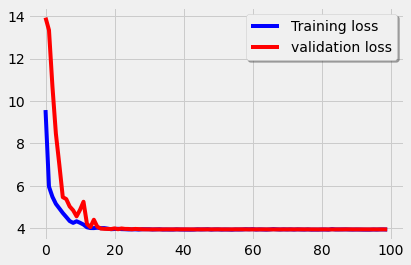

In [18]:
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.legend(loc='best', shadow=True)
plt.show()